# 1. Setup


In [1]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image
import torch

from socket import timeout

from google.colab import files

!pip3 install -q torch torchvision
!pip3 install -q Pillow

device = torch.device("cuda:0") # Let's make sure GPU is available!

#  2 Create train Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Here is one example of an image in the dataset, with its corresponding annotations boundig box
import os

dog_dataset_path = '/content/drive/My Drive/fourthbrain/dog_dataset/train' # Replace with actual path
train_image_dir = os.path.join(dog_dataset_path, 'images/')
#image_names = os.listdir(train_image_dir)

#print(image_names)
#from PIL import Image
#Image.open(train_image_dir+'dog_001.jpg')

In [4]:

from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline


Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
dot_dataset/
  test/
    annotations/xmls/ 
      dog_011.xml
      dog_012.xml
      dog_013.xml
      dog_050.xml
    images/
      dog_011.jpg
      dog_012.jpg
      dog_013.jpg
      dog_050.jpg
    ...
  train/
    annotations/xmls/ 
      dog_001.xml
      dog_002.xml
      dog_003.xml
      dog_010.xml
    images/
      dog_001.jpg
      dog_002.jpg
      dog_003.jpg
      dog_010.jpg
```

Let's read the annotations (including the ground-truth bounding boxes) for these training images. And plot these bounding boxes on their respective images.

In [5]:
import xml.etree.ElementTree as ET
from typing import Tuple

def read_content(xml_file: str, h: int, w: int) -> Tuple[str, list]:
    """ parse metadata/annotation 
    
    Args:
        xml_file (str): path to a xml file
        h (int): height
        w (int): width
        
    Return:
        Tuple[str, list]: 
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):
        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None
        ymin = int(boxes.find("bndbox/ymin").text) / h
        ymax = int(boxes.find("bndbox/ymax").text) / h
        xmin = int(boxes.find("bndbox/xmin").text) / w
        xmax = int(boxes.find("bndbox/xmax").text) / w

        list_with_single_boxes = [ymin, xmin, ymax, xmax]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes


Bounding box for image 0:  [[0.1890625  0.31458333 0.540625   1.20208333]]
Bounding box for image 1:  [[0.23125    0.24166667 0.4890625  0.89166667]]
Bounding box for image 2:  [[0.0015625  0.00208333 0.3515625  0.70416667]]
Bounding box for image 3:  [[0.140625   0.3375     0.6125     0.82291667]]
Bounding box for image 4:  [[0.1125     0.26458333 0.703125   0.95833333]]
Bounding box for image 5:  [[0.0234375  0.26666667 0.6796875  0.91666667]]
Bounding box for image 6:  [[0.153125   0.24791667 0.4859375  0.92916667]]
Bounding box for image 7:  [[0.1203125  0.25625    0.41875    0.98333333]]
Bounding box for image 8:  [[0.1859375  0.34166667 0.45625    0.84166667]]
Bounding box for image 9:  [[0.153125   0.32916667 0.5625     1.18125   ]]


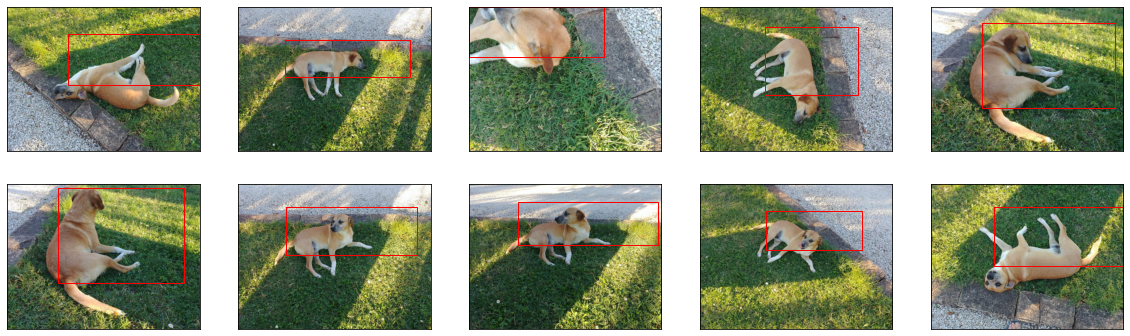

In [6]:
class DogDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.folder = folder

        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(folder, "images")))) #os.listdir
        self.annot = list(sorted(os.listdir(os.path.join(folder, "annotations"))))

        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):        
        img_path = os.path.join(self.folder, "images", self.imgs[idx])
        mask_path = os.path.join(self.folder, "annotations", self.annot[idx])

        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        
        w,h,c = img.shape
        _, bounding_box = read_content(mask_path, h, w)
        bounding_box = np.array(bounding_box)
        #img = img.transpose((2, 0, 1))


        if self.transform is not None:
            img = self.transform(img)

        return img, bounding_box

def visualize_samples(dataset, indices, h, w, count=10):
    # visualize train 10 samples

    plt.figure(figsize=(count*2,6))
    display_indices = indices[:count]

    for i, index in enumerate(display_indices):    
        x, y = dataset[index] 
        #x = x.transpose((1, 2, 0)) 

        ax = plt.subplot(2,int(count/2),i+1)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)

        #(startX, startY, endX, endY) = y.astype("int") [ymin, xmin, ymax, xmax]
			  # draw the bounding box and label on the frame
			  #label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
			  #cv2.rectangle(orig, (startX, startY), (endX, endY), COLORS[idx], 2)


   
        ax.imshow(x)
        (ymin, xmin, ymax, xmax) = y[0]
        print(f'Bounding box for image {i}: ', y)
        ymin_1 = int(ymin* h)
        ymax_1 = int(ymax* h)
        xmin_1 = int(xmin* w)
        xmax_1 = int(xmax* w)

        # Get the current reference
        ax = plt.gca()

        # Create a Rectangle patch
        width = abs(xmax_1 - xmin_1)
        height = abs(ymax_1 - ymin_1)
        rect = Rectangle((xmin_1,ymin_1),width,height,linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.imshow(x)


train_dataset = DogDataset(dog_dataset_path)
# print(len(train_dataset)) # 10
indices = np.arange(len(train_dataset))

visualize_samples(train_dataset, indices, 480, 640)



In [7]:
train_dataset[0][0].shape

(480, 640, 3)

# Let's write some helper functions for data augmentation / transformation

In [8]:
from torchvision import transforms as T

def get_transform(train):
    return T.Compose([
          transforms.Resize((192, 256)),
          transforms.ToTensor(),
          # Use mean and std for pretrained models
          # https://pytorch.org/docs/stable/torchvision/models.html
          #transforms.Normalize(mean=[0.485, 0.456, 0.406],
          #      std=[0.229, 0.224, 0.225])                         
      ])


# 2 Train Dataloader

In [9]:
from torchvision import transforms as T

# without Random Sampler
batch_size = 1 #len(train_dataset)

train_dataset = DogDataset(dog_dataset_path, transform=T.Compose([
          transforms.ToTensor(),
          transforms.Resize((48,48)),
          
          # Use mean and std for pretrained models
          # https://pytorch.org/docs/stable/torchvision/models.html
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])                         
      ]))
print(train_dataset)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched[0].size(),
          sample_batched[1].size())
    print(sample_batched[0].numel())

0 torch.Size([1, 3, 48, 48]) torch.Size([1, 1, 4])
6912
1 torch.Size([1, 3, 48, 48]) torch.Size([1, 1, 4])
6912
2 torch.Size([1, 3, 48, 48]) torch.Size([1, 1, 4])
6912
3 torch.Size([1, 3, 48, 48]) torch.Size([1, 1, 4])
6912
4 torch.Size([1, 3, 48, 48]) torch.Size([1, 1, 4])
6912
5 torch.Size([1, 3, 48, 48]) torch.Size([1, 1, 4])
6912
6 torch.Size([1, 3, 48, 48]) torch.Size([1, 1, 4])
6912
7 torch.Size([1, 3, 48, 48]) torch.Size([1, 1, 4])
6912
8 torch.Size([1, 3, 48, 48]) torch.Size([1, 1, 4])
6912
9 torch.Size([1, 3, 48, 48]) torch.Size([1, 1, 4])
6912


# 3 Load and run object detection model

This model is an SSD (single shot multibox detector) object detetion with Resnet50 backbone with feature pyramid network. You can choose other models, such as YOLO, feasterRCNN, etc.

**Model 1:** SSD_Resnet50_FPN (tensorflow.org/models/object_detection)

SSD300 and SSD512. (2016 year)

SSD300: 300×300 input image, lower resolution, faster.

SSD512: 512×512 input image, higher resolution, more accurate.
For 300 × 300 input, SSD achieves 74.3% mAP1 on VOC2007 test at 59 FPS on a Nvidia Titan X and 

for 512 × 512 input, SSD achieves 76.9% mAP, outperforming a comparable state-of-the-art Faster R-CNN model.

**Model 2:** ssd300_vgg16 (Pytorch models)

**Model 3:** FasterRCNN_ResNet50_FPN (Pytorch models)

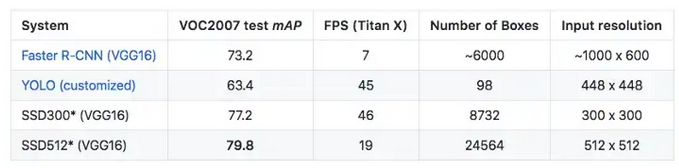

Use the following code to make some predictions before fine-tuning. The model by default will generate 100 possible objects, each with associated confidence scores and predicted classes.

In [10]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights,fasterrcnn_resnet50_fpn



# Step 1: Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights)#, box_score_thresh=0.5)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


  0%|          | 0.00/167M [00:00<?, ?B/s]

In [11]:
# Run on Image


# move model to the right device
#model.to(device)

model.eval()

img = Image.open(train_image_dir+'dog_001.jpg').convert("RGB")
img = np.array(img)

def img_transform(img):
  img = img.transpose((2, 0, 1))
  img = torch.from_numpy(img)
  return img

img = img_transform(img)
print(img.dim())
# Step 2: Initialize the inference transforms ??????
preprocess = weights.transforms()

batch = [preprocess(img)] # images is expected to be a list of 3d tensors of shape [C, H, W], got torch.Size([480, 640])
#img = img.to(device)

#print(train_dataset[0][0].size())

prediction = model(batch)[0]


print(prediction.keys())
print(prediction['labels'])
#labels = weights.meta["categories"][prediction['labels'].detach()]
labels = [weights.meta["categories"][label] for label in prediction['labels']]
print(labels)
print(" ")
print(prediction['scores'])





3
dict_keys(['boxes', 'labels', 'scores'])
tensor([18, 34])
['dog', 'frisbee']
 
tensor([0.9958, 0.0596], grad_fn=<IndexBackward0>)


To begin with, let's see what the already trained network (FasterRCNN) inference in our images. That is, let's see which of the 100 classes the network will assign them to.

Run the model on 10 random pictures from the dataset and output them along with the classes with the highest score.

In [12]:
# Run on Dataset 

train_dataset = DogDataset(dog_dataset_path)
# print(len(train_dataset)) # 10
indices = np.arange(len(train_dataset))

def pretrained_infer(train_dataset, model):
  model.to(device)
  model.eval()

  max_boxes = []
  for i in range(len(train_dataset)):
      sample, _ = train_dataset[i]
      sample = img_transform(sample)

      sample_gpu = sample.to(device)
      sample_gpu = [preprocess(sample_gpu)]
      output = model(sample_gpu)[0] 
      #boxes=output['boxes']
      #print(boxes.shape)
      #labels = [weights.meta["categories"][label] for label in output['labels']]
      #print(labels)

      bx=output['boxes'][output['scores'] > 0.8]
      bx = bx.cpu().detach().numpy()
      max_boxes.append(bx)
    
  return max_boxes

In [13]:
max_boxes = pretrained_infer(train_dataset, model)
max_boxes

[array([[150.15367, 122.49713, 577.784  , 348.9879 ]], dtype=float32),
 array([[107.54594, 141.05917, 425.55392, 315.4539 ]], dtype=float32),
 array([[0.0000000e+00, 3.4673768e-01, 3.4903625e+02, 2.2261729e+02]],
       dtype=float32),
 array([[161.61787,  87.82147, 400.88544, 393.6011 ]], dtype=float32),
 array([[127.70803,  69.76892, 464.7855 , 462.688  ]], dtype=float32),
 array([[130.32315 ,   9.751538, 443.50223 , 450.6737  ]], dtype=float32),
 array([[116.60244,  95.75758, 445.9435 , 307.96204]], dtype=float32),
 array([[118.65951,  73.66637, 465.9033 , 268.70358]], dtype=float32),
 array([[164.61032, 119.54482, 407.60648, 296.92166]], dtype=float32),
 array([[148.03879,  95.94055, 573.9638 , 362.93298]], dtype=float32)]

Run to the batch examples from Train Loader

In [14]:
# Run the model on train dataset 
def just_in_case():
  train_dataset = DogDataset(dog_dataset_path)
  # print(len(train_dataset)) # 10
  indices = np.arange(len(train_dataset))

  #visualize_samples(train_dataset, indices, 480, 640)
  max_boxes = []
  for i in range(len(train_dataset)):
      sample, _ = train_dataset[i]
      sample = img_transform(sample)

      sample_gpu = sample.to(device)
      sample_gpu = [preprocess(sample_gpu)]
      output = model(sample_gpu)[0] 
      boxes=output['boxes']
      print(boxes.shape)
      labels = [weights.meta["categories"][label] for label in output['labels']]
      print(labels)

      print(" ")
      labels3=output['labels'][output['scores'] > 0.8]
      print(labels3 )    
      print(" ")
      bx=output['boxes'][output['scores'] > 0.8]
      bx = bx.cpu().detach().numpy()
      max_boxes.append(bx)

In [15]:
len(max_boxes)

10

In [16]:
# visualize_predict_boxes on 1 image (not necessary)
def visualize_one_image():
  h = 1
  w = 1
  x = sample
  x = x.squeeze(dim=0)
  x = x.permute(1,2,0).detach().numpy()
  x = x.astype(np.uint8)

  ax = plt.subplot(1,1,1)
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)
  ax.imshow(x)

  for i in range(0,len(max_boxes)): # boxes_cpu
    (ymin, xmin, ymax, xmax) = max_boxes[9][0]

    ymin_1 = int(ymin* h)
    ymax_1 = int(ymax* h)
    xmin_1 = int(xmin* w)
    xmax_1 = int(xmax* w)

    # Get the current reference
    ax = plt.gca()

    # Create a Rectangle patch
    width = abs(xmax_1 - xmin_1)
    height = abs(ymax_1 - ymin_1)
    rect = Rectangle((xmin_1,ymin_1),width,height,linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
  plt.imshow(x)



Bounding box for image 0:  [150.15367 122.49713 577.784   348.9879 ]
Bounding box for image 1:  [107.54594 141.05917 425.55392 315.4539 ]
Bounding box for image 2:  [0.0000000e+00 3.4673768e-01 3.4903625e+02 2.2261729e+02]
Bounding box for image 3:  [161.61787  87.82147 400.88544 393.6011 ]
Bounding box for image 4:  [127.70803  69.76892 464.7855  462.688  ]
Bounding box for image 5:  [130.32315    9.751538 443.50223  450.6737  ]
Bounding box for image 6:  [116.60244  95.75758 445.9435  307.96204]
Bounding box for image 7:  [118.65951  73.66637 465.9033  268.70358]
Bounding box for image 8:  [164.61032 119.54482 407.60648 296.92166]
Bounding box for image 9:  [148.03879  95.94055 573.9638  362.93298]


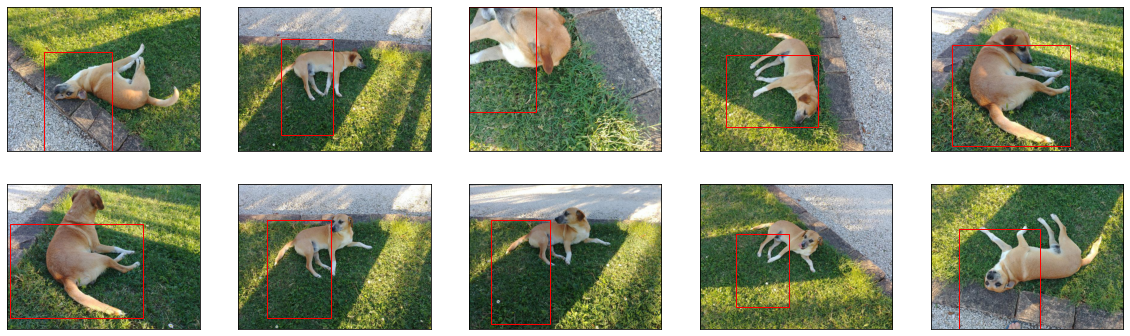

In [17]:
# visualize inference boxes on dataset
def visualize_inference_samples(dataset, indices, boxes, h=1, w=1, count=10):
    # visualize train 10 samples

    plt.figure(figsize=(count*2,6))
    display_indices = indices[:count]

    for i, index in enumerate(display_indices):    
        x, _ = dataset[index] 
        #x = x.transpose((1, 2, 0)) 

        ax = plt.subplot(2,int(count/2),i+1)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)

        #(startX, startY, endX, endY) = y.astype("int") [ymin, xmin, ymax, xmax]
			  # draw the bounding box and label on the frame
			  #label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
			  #cv2.rectangle(orig, (startX, startY), (endX, endY), COLORS[idx], 2)


   
        ax.imshow(x)
        (ymin, xmin, ymax, xmax) = boxes[i][0]
        print(f'Bounding box for image {i}: ', boxes[i][0])
        ymin_1 = int(ymin* h)
        ymax_1 = int(ymax* h)
        xmin_1 = int(xmin* w)
        xmax_1 = int(xmax* w)

        # Get the current reference
        ax = plt.gca()

        # Create a Rectangle patch
        width = abs(xmax_1 - xmin_1)
        height = abs(ymax_1 - ymin_1)
        rect = Rectangle((xmin_1,ymin_1),width,height,linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.imshow(x)


train_dataset = DogDataset(dog_dataset_path)
# print(len(train_dataset)) # 10
indices = np.arange(len(train_dataset))

visualize_inference_samples(train_dataset, indices, max_boxes)

# 4. Fine-tune (in progress)